In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle
import os
from PIL import Image
from torchvision import transforms
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class test(nn.Module):
    def __init__(self):
        super(test, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding=1)  # Changed from 3 to 4 channels
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        # Dropout layers
        self.dropout25 = nn.Dropout(0.25)
        self.dropout50 = nn.Dropout(0.5)
        
        # Fully connected layers
        # Calculate the correct input size
        self.fc1_input_size = self._get_conv_output_size((4, 400, 400))
        self.fc1 = nn.Linear(self.fc1_input_size, 512)  # Adjusted dynamically
        self.bn_fc = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 1)
        
    def _forward_features(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout25(x)
        
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout25(x)
        
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout50(x)

        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = self.dropout50(x)
        return x

    def _get_conv_output_size(self, input_size):
        with torch.no_grad():
            input = torch.rand(1, *input_size)
            output = self._forward_features(input)
            return output.data.view(1, -1).size(1)
        
    def forward(self, x):
        x = self._forward_features(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.bn_fc(self.fc1(x)))
        x = self.dropout50(x)
        x = F.relu(self.fc2(x))
        return x

model = test()
print(model)

test(
  (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout25): Dropout(p=0.25, inplace=False)
  (dropout50): Dropout(p=0

In [5]:
def data_generator(folder_paths=["data/", "data2/", "data3/"], batch_size=32, image_size=(400, 400)):
    transform = transforms.Compose([
        transforms.ToTensor(),  # Converts to torch.Tensor and scales to [0, 1]
        transforms.Resize(image_size),  # Resize the image
    ])

    # Create a list of all possible image paths
    all_files = []
    for folder_path in folder_paths:
        for i in range(len(os.listdir(folder_path))//2):  # Assuming each folder has 4000 images
            image_path = os.path.join(folder_path, f"{i}.png")
            if os.path.exists(image_path):  # Ensure the file exists
                all_files.append((folder_path, i))

    # Shuffle the list to randomize the order of files
    np.random.shuffle(all_files)

    images, labels = [], []
    for folder_path, i in all_files:
        image_path = os.path.join(folder_path, f"{i}.png")
        # Load and preprocess the image
        image = Image.open(image_path)
        tensor_image = transform(image)

        with open(os.path.join(folder_path, f"{i}_catalog.pkl"), "rb") as f:
            info = pickle.load(f)
        if info["exist"]:
            labels.append(info["radius"]/1000)
            images.append(tensor_image)
        if len(images) == batch_size:
            yield torch.stack(images), (labels)
            images, labels = [], []  # Reset for next batch

    # Yield any remaining data as the last batch
    if images:
        yield torch.stack(images), torch.tensor(labels)

In [6]:
import random
criterion = torch.nn.L1Loss()

# Specify the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Example of using the generator to train the model
num_epochs = 10  # Specify the number of epochs
batch_size = 32
loss_function = torch.nn.GaussianNLLLoss(eps=1e-02, # Epsilon for numerical stability
                                full=False, # Computes the necessary terms AND the constants
                                reduction="mean" # Alternative is 'sum' or 'none'
                                )
model.train()  # Set the model to training mode

for epoch in range(200):
    count = 0
    for input, output in data_generator():
        count += 1
        # Reset the gradients
        optimizer.zero_grad()

        # Forward pass: Compute predicted y by passing x to the model
        # Compute and print loss
        nn_output = model(input)
        # loss = criterion(nn_output[:, 0], torch.tensor(output))
        loss = criterion(nn_output[:, 0], target = torch.FloatTensor(output))
        # loss += criterion(nn_output[:, 1], target = torch.tensor([coord[1][0] for coord in output]))
        # loss += criterion(nn_output[:, 2], target = torch.tensor([coord[1][1] for coord in output]))
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
        if count % 5 == 0:
            print(nn_output) 
            # print(criterion(nn_output[:, 0], torch.tensor([radius[0] for radius in output])))
            # print(criterion(nn_output[:, 1], target = torch.tensor([coord[1][0] for coord in output])))
            # print(criterion(nn_output[:, 2], target = torch.tensor([coord[1][1] for coord in output])))
        # Perform a backward pass to calculate the gradients
        loss.backward()

            # Update the parameters
        optimizer.step()

In [4]:
from prior import Cluster_Prior
a = Cluster_Prior()
b,c,d, e = a.sample()

/home/shihangl/bliss/.venv/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
c

[642.4241922656728]

In [6]:
d

[[]]

In [3]:
import pandas as pd
pd.DataFrame(b[0])

,RA,DEC,X,Y,FLUX_R,MAG_R,FLUX_G,MAG_G,FLUX_I,MAG_I,FLUX_Z,MAG_Z,TSIZE,FRACDEV,G1,G2
0,50.677746,-40.355881,3086.015550,212.598034,1283.348802,22.229138,2885.294697,21.349525,1923.878254,21.789556,4716.652370,20.815915,0.090908,0,-0.098658,0.043308
1,50.755407,-40.153325,4483.908719,3858.612651,386.762279,23.531390,976.449015,22.525876,600.982220,23.052846,1269.803800,22.240658,0.057785,0,0.001467,-0.008109
2,50.688501,-40.355789,3279.601115,214.258288,294.421447,23.827576,636.363570,22.990737,348.677576,23.643940,526.722146,23.196046,0.054367,0,0.012169,0.280610
3,50.684779,-40.242423,3212.595450,2254.838651,5577.480354,20.633905,11332.807816,19.864156,7094.901914,20.372634,12554.064544,19.753039,0.248012,0,-0.036537,0.187369
4,50.549119,-40.326868,770.724803,734.832462,10082.936263,19.991032,22420.687888,19.123378,15396.111780,19.531472,29506.786753,18.825195,0.410116,0,0.005558,-0.026597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1983,50.565427,-40.120810,1064.272367,4443.874843,164.804525,24.457577,187.332807,24.318465,125.315150,24.754991,196.807144,24.264898,0.049568,0,-0.019087,0.039652
1984,50.705242,-40.337862,3580.941424,536.936316,153.599403,24.534026,159.447912,24.493453,64.339631,25.478804,193.288746,24.284484,0.049153,0,-0.098165,0.160761
1985,50.601854,-40.093381,1719.947737,4937.591103,141.017299,24.626819,146.421307,24.585989,150.451484,24.556509,380.551095,23.548968,0.048687,0,-0.433719,-0.027065
1986,50.751544,-40.347956,4414.376771,355.239779,249.249191,24.008416,369.237856,23.581734,750.551302,22.811549,1484.788807,22.070838,0.052695,0,-0.054835,-0.031803


(array([1.953e+03, 1.000e+01, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.07094430e+02, 4.07926974e+04, 8.14783003e+04, 1.22163903e+05,
        1.62849506e+05, 2.03535109e+05, 2.44220712e+05, 2.84906315e+05,
        3.25591918e+05, 3.66277521e+05, 4.06963124e+05]),
 <BarContainer object of 10 artists>)

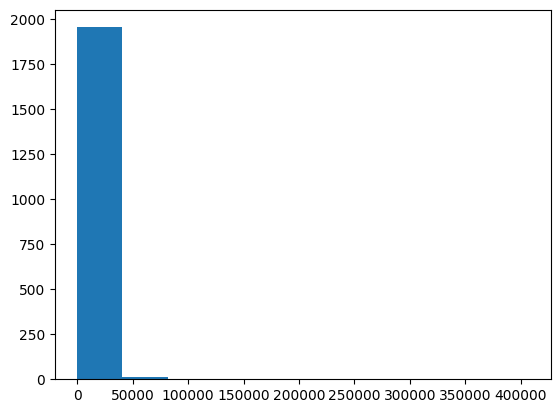

In [17]:
plt.hist(b[0]["FLUX_R"])